This Notebook imports and explores the training dataset for the Kaggle SF Crime problem
https://www.kaggle.com/c/sf-crime

Current Exploration:
- Count unique values for each variable
- View most common values

Future Exploration:
- XY plot of lat/long w. circles to indicate number of crimes (and colors to show category?)
- Time series plots to see how category use changes over time



Interesting Points:
- Most crime on Friday, then Wednesday. Least on Sunday.
- X and Y latitude have same number of distinct values. Seem to be somehow linked to locations
  since, despite there being a lots of sig fig, they still can be frequency counted
- 800 Block of BRYANT ST has 4x+ more data points than anyplace else. Seems to link w/ most freq X and Y
- "Other Offenses" are common
- The dates with the most crime are new years day. Also the first of months.
- Note: Strange max value of Y = 90 for 67 values. These appear to be in Chicago, but the data has addresses in SF.


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


In [259]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")


In [261]:
# Clean some variables, parse out dates for time-series analysis
data['Dates'] = pd.to_datetime(data['Dates'])
data['Year'] = data.Dates.dt.year
data['Month'] = data.Dates.dt.month
data['Day'] = data.Dates.dt.day
data['Date'] = data.Dates.dt.date
data['Hour'] = data.Dates.dt.hour
data['DayOfYear'] = data.Dates.dt.dayofyear
data.dtypes


Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Year                   int64
Month                  int64
Day                    int64
Date                  object
Hour                   int64
DayOfYear              int64
dtype: object

In [262]:
# Count distinct for each variable:
print "There are a total of {:,}, values.".format(len(data))

for var, series in data.iteritems():
    print "There are a total of {:,} {}.".format(len(series.value_counts()), var)


There are a total of 878,049, values.
There are a total of 389,257 Dates.
There are a total of 39 Category.
There are a total of 879 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 17 Resolution.
There are a total of 23,228 Address.
There are a total of 34,243 X.
There are a total of 34,243 Y.
There are a total of 13 Year.
There are a total of 12 Month.
There are a total of 31 Day.
There are a total of 2,249 Date.
There are a total of 24 Hour.
There are a total of 338 DayOfYear.


In [263]:
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "Resolution", "DayOfWeek","Year","Month","Day","Hour"]
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values, as follows: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts()
    print

-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE          

In [264]:
# View Top 15 of Dates, Descript, Address, X, Y
variables = ["Dates", "Descript", "Address", "X", "Y", "Date", "DayOfYear"]
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values. The top 15 are: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts().head(15)
    print


-------------------------------------------------------------------------
There are a total of 389,257 distinct Dates values. The top 15 are: 
2011-01-01 00:01:00    185
2006-01-01 00:01:00    136
2012-01-01 00:01:00     94
2006-01-01 12:00:00     63
2007-06-01 00:01:00     61
2006-06-01 00:01:00     58
2010-06-01 00:01:00     56
2010-08-01 00:01:00     55
2008-04-01 00:01:00     53
2013-11-01 00:01:00     52
2006-07-01 00:01:00     51
2013-05-01 00:01:00     51
2008-11-01 00:01:00     51
2010-11-01 00:01:00     51
2005-06-01 00:01:00     50
dtype: int64

-------------------------------------------------------------------------
There are a total of 879 distinct Descript values. The top 15 are: 
GRAND THEFT FROM LOCKED AUTO                 60022
LOST PROPERTY                                31729
BATTERY                                      27441
STOLEN AUTOMOBILE                            26897
DRIVERS LICENSE, SUSPENDED OR REVOKED        26839
WARRANT ARREST                           

In [265]:
# Describe floats
print data.describe()

# Note - strange max value of Y = 90 degrees

                   X              Y           Year          Month  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean     -122.422616      37.771020    2008.712046       6.436509   
std         0.030354       0.456893       3.631194       3.428972   
min      -122.513642      37.707879    2003.000000       1.000000   
25%      -122.432952      37.752427    2006.000000       3.000000   
50%      -122.416420      37.775421    2009.000000       6.000000   
75%      -122.406959      37.784369    2012.000000       9.000000   
max      -120.500000      90.000000    2015.000000      12.000000   

                 Day           Hour      DayOfYear  
count  878049.000000  878049.000000  878049.000000  
mean       15.570623      13.412655     180.332158  
std         8.783005       6.549573     104.897857  
min         1.000000       0.000000       1.000000  
25%         8.000000       9.000000      90.000000  
50%        16.000000      14.000000     179.000000  
75%    

In [266]:
outlier = data[data.Y == 90]
print "There are {} outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.".format(len(outlier))
print "We have saved the outliers separately, then will remove them from the data for plotting."
# The line below prints a table with all outliers. It looks cleaner if we do not use "print" because Pandas has
# nice formatting:
# outlier

data_clean = data[data.Y != 90]


There are 67 outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.
We have saved the outliers separately, then will remove them from the data for plotting.


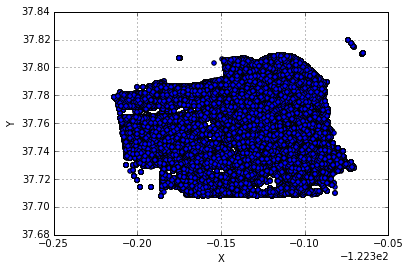

In [50]:
# Plot coordinates - basic plot
data_clean.plot(kind='scatter', x='X', y='Y')

The number of observations to plot is condensed from 877,982 to 34,242.


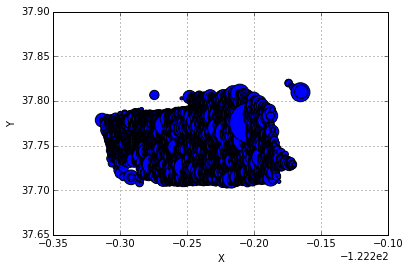

In [103]:
# Let's freq first, then set the size of the dot by the number of crimes
loc_freq = data_clean.groupby(by=['X','Y']).size().reset_index()
print "The number of observations to plot is condensed from {:,} to {:,}.".format(len(data_clean),len(loc_freq))

loc_freq.plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]))
#Not as helpful as I would have hoped, just too much going on w/out limiting the data.

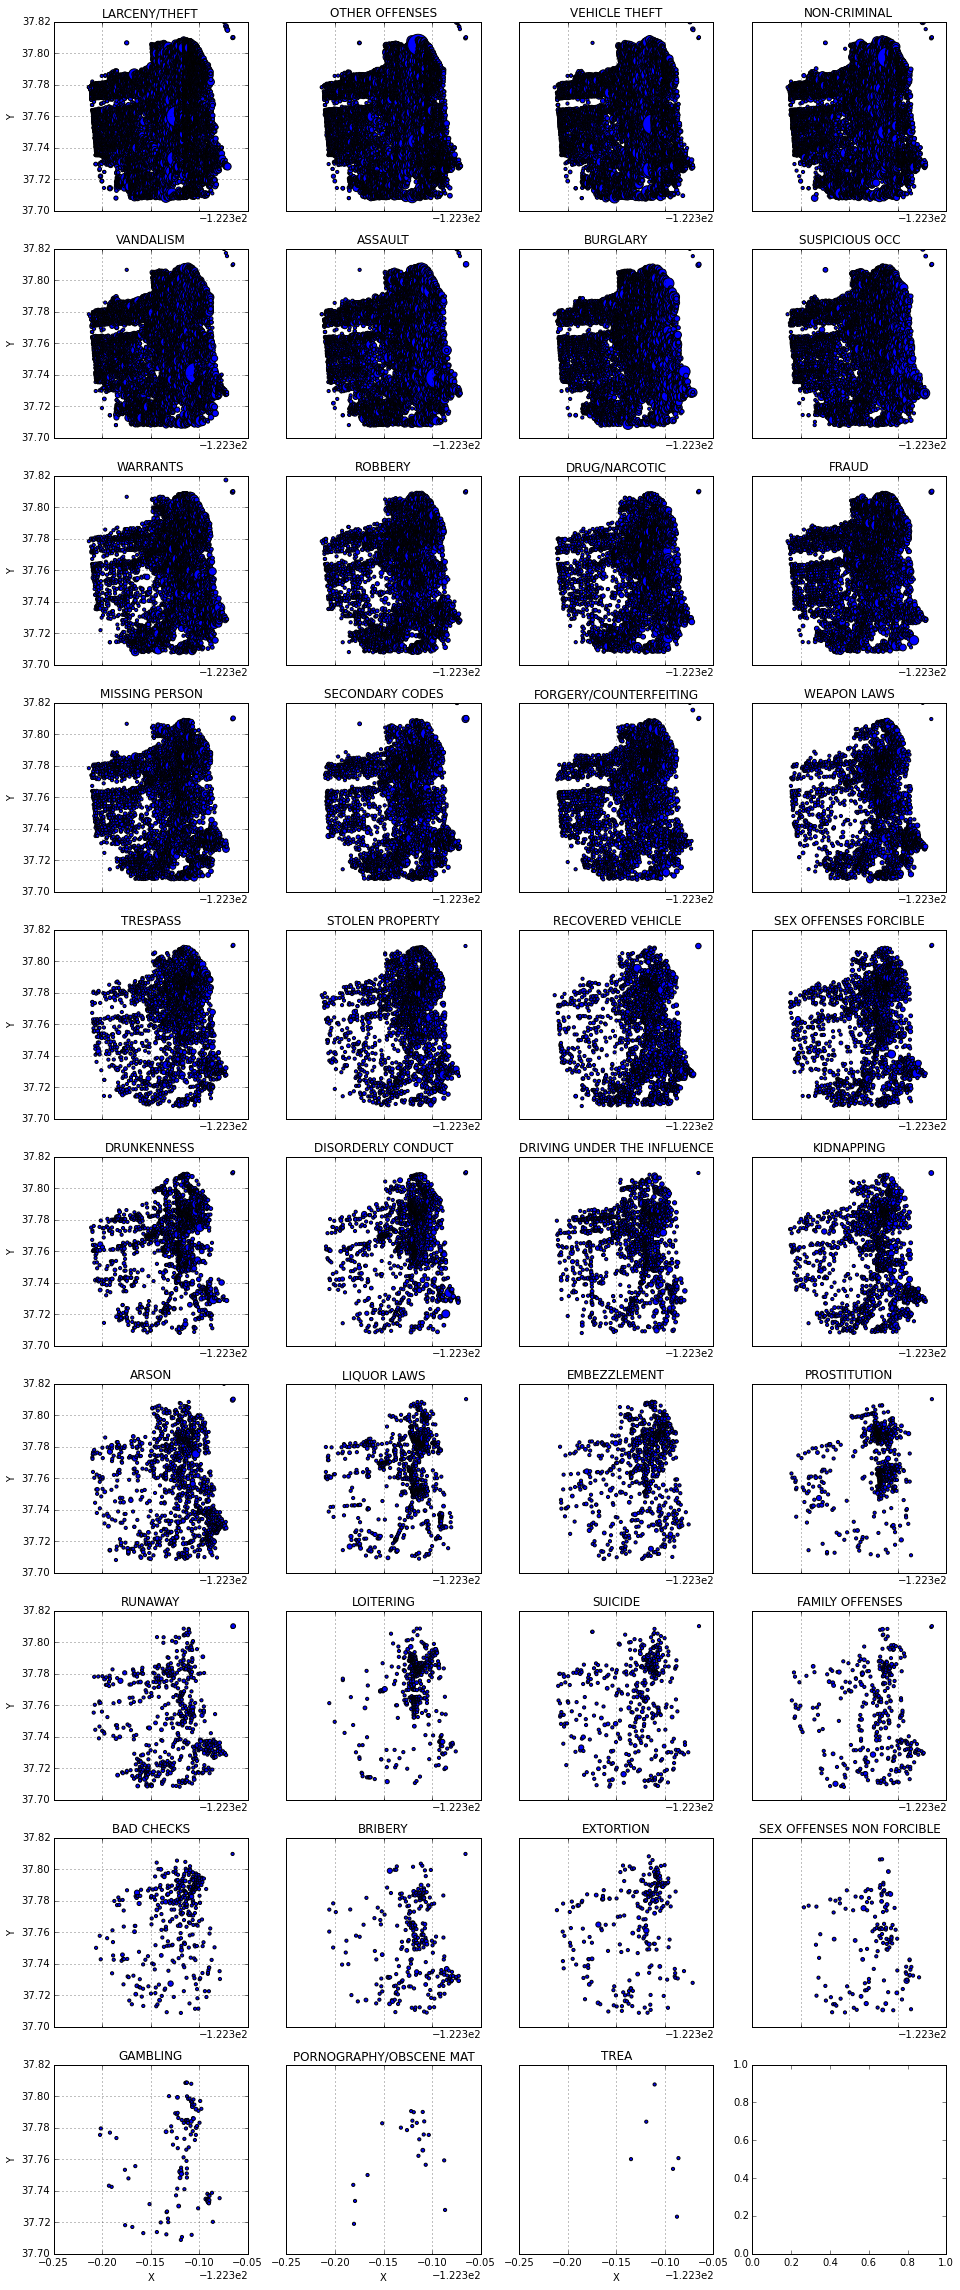

In [187]:
# Let's create one plot per category...
loc_freq = data_clean.groupby(by=['Category','X','Y']).size().reset_index()
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(16, 40))
for i,var in enumerate(loc_freq.Category.value_counts().index):
    loc_freq[loc_freq.Category == var].plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]), 
                                            ax=axes[i/4, i%4], title=var, xlim=(-122.55,-122.35), ylim=(37.7,37.82))
    if i%4 != 0:
        axes[i/4, i%4].get_yaxis().set_visible(False)

# I don't see much of a pattern. Maybe sometimes a little.

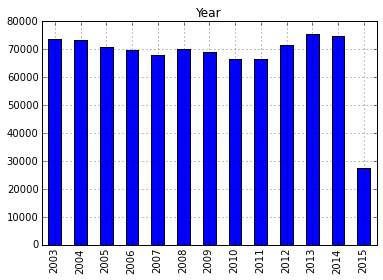

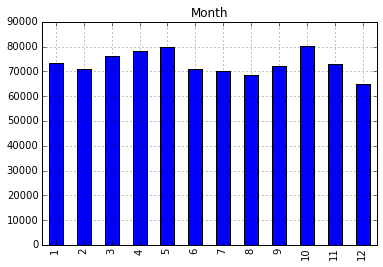

In [279]:
# Let's look at entries over time...
data_clean['Dates'].groupby(data_clean.Dates.dt.year).count().plot(kind="bar", title="Year")
plt.show()
data_clean['Dates'].groupby(data_clean.Dates.dt.month).count().plot(kind="bar", title="Month")
plt.show()

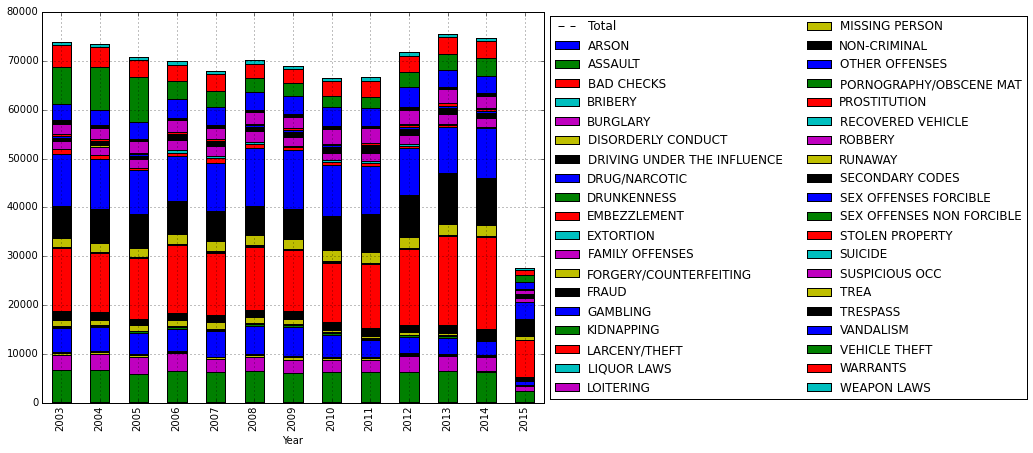

In [368]:
# Look at categories over time
data['Count'] = 1

sub_data = data[['Count','Year','Category']]
category_group = sub_data.groupby(['Year','Category']).sum()
plot = category_group.unstack().plot(kind='bar', stacked=True, figsize=(9, 7), legend=False)

# Prepare legend
leg = np.sort(pd.unique(data.Category))
leg = np.insert(leg, 0, "Total")

plot.legend(leg, loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)

# Many categories remain generally stable. Larceny increases, while Vehicle Theft falls.